# Lecture 22 - Nonlinear regression

In [1]:
## Import packages

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import seaborn as sns

# Important for regression, curve fitting, smoothing
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn import linear_model

# Set size of font for matplotplib
plt.rc('font', size=12) 

print("Done importing packages :)")

Done importing packages :)


-----

## Fitting data to curves

Today we'll see many examples of how to find curves or functions that fit our data. However, perhaps the most important lesson is the one in the following code block. Curve fitting is a blanace between finding a function that approprately fits the data we have, and using a function that is general enough to reasonably help us make expectations about what new data might look like. Consider the example below.

(-1, 1)

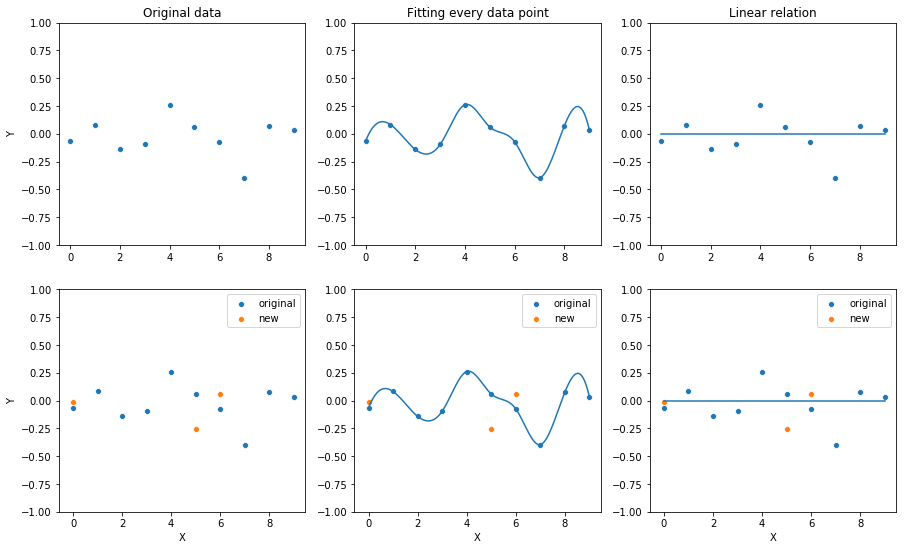

In [2]:
# Make some fake x data
x = np.arange(10)

# Now choose y values that all come from the same normal distribution
y = np.random.normal(0,0.2,x.size)

# Draw a scatterplot of the data
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
sns.scatterplot(x,y)
plt.title("Original data")
plt.ylabel("Y")
plt.ylim(-1,1)

# Let's draw a curve that really nicely hits every point in our data
interpolated_function_y = interp1d(x, y, kind='cubic')

# Plot this function atop the scatter
plt.subplot(2,3,2)
sns.scatterplot(x,y)
sns.lineplot(np.linspace(0,9,1000), interpolated_function_y(np.linspace(0,9,1000)))
plt.title("Fitting every data point")
plt.ylim(-1,1)

# But really we just have data distributed along the vertical line y=0. So the actual relation is linear.
plt.subplot(2,3,3)
sns.scatterplot(x,y)
sns.lineplot(x, np.zeros(x.size))
plt.title("Linear relation")
plt.ylim(-1,1)


# Okay so obviously the interpolated curve fits better. But the real test comes when we get NEW data.
# How well do our fits predict where new data might lie?

# Make 3 new data points
x_new = np.random.randint(9, size =3)
y_new = np.random.normal(0,0.2,x_new.size)

# Draw the updated scatterplot
plt.subplot(2,3,4)
sns.scatterplot(x,y, label = "original")
sns.scatterplot(x_new,y_new, label = "new")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-1,1)

# Would these new points fall near our original highly complicated curve?
plt.subplot(2,3,5)
sns.scatterplot(x,y, label = "original")
sns.lineplot(np.linspace(0,9,1000), interpolated_function_y(np.linspace(0,9,1000)))
sns.scatterplot(x_new,y_new, label = "new")
plt.xlabel("X")
plt.ylim(-1,1)

# What about the line?
plt.subplot(2,3,6)
sns.scatterplot(x,y, label = "original")
sns.lineplot(x, np.zeros(x.size))
sns.scatterplot(x_new,y_new, label = "new")
plt.xlabel("X")
plt.ylim(-1,1)

# plt.savefig("fig0.pdf")

------
## ATCase revisited

Last class we used the ATCase activity data and attempted to fit a line to these data. How did that go?


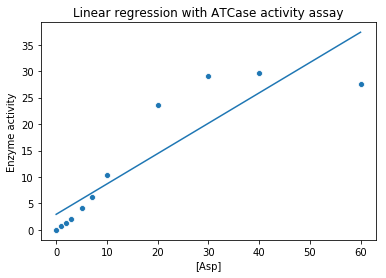

In [3]:
# ATCase data
asp = np.array([0, 1, 2, 3, 5, 7, 10, 20, 30, 40, 60])
specific_activity = np.array([0, 0.6814, 1.2617, 2.07858, 4.05992, 6.1683, 10.44972, 23.56204, 28.99312, 29.62764, 27.60816])

# Plot the data
sns.scatterplot(asp, specific_activity)

# Calculate line of best fit
# from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(asp.reshape(-1,1), specific_activity.reshape(-1,1))
a_atcase = regr.intercept_
b_atcase = regr.coef_[0]

y_hats_atcase = a_atcase + b_atcase*asp

# Plot the line of best fit
sns.lineplot(asp,y_hats_atcase )
plt.xlabel("[Asp]")
plt.ylabel('Enzyme activity')
plt.title('Linear regression with ATCase activity assay');

# plt.savefig("fig1.pdf")

### So.... 
that went pretty badly. Why??

The relationship between the aspartate concentration and the activity of the enzyme is *nonlinear*. That is, we cannot use an equation of the form $y = a + bx$ to describe the relationship. We need a curvier function to describe the relationship.

## Michaelis-Menten kinetics

Let's say we have an enzyme that performs the following reaction
    $$ Enzyme + Substrate \rightleftharpoons EnzymeSubstrate \rightarrow Enzyme + Product $$
    
or more simply

$$E + S \rightleftharpoons^{k_f}_{k_r} ES \rightarrow^{k_{cat}} E + P $$


Under reasonable assumptions, we can then solve for the enzyme velocity

$$ velocity = \frac{d[P]}{dt} = V_{max}\frac{[S]}{K_m + [S]} $$

where $V_{max}$ is the maximum velocity of the enzyme and $K_m$ is the concentration of S at which the eznyme velocity is half of maximum. Ribonuclease, pepsin, T-RNA synthetase, and many more enzymes follow Michaelis Menten kinetics.

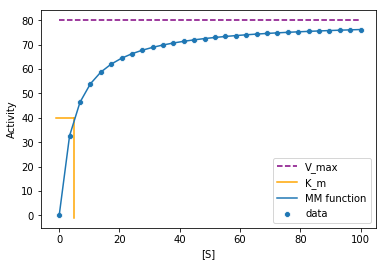

In [4]:
## Example MM kinetics curve - note the asymptote at V_max

substrate = np.linspace(0,100,30)  # mM concentration
V_max = 80
K_m = 5
product = V_max * (substrate/(K_m + substrate))

sns.scatterplot(substrate, product, label = "data")
ax =sns.lineplot(substrate, V_max*np.ones(substrate.shape), dashes=[(6, 1)], label = "V_max", color = "purple")
ax.lines[0].set_linestyle("--")
plt.plot([K_m, K_m], [-1, 0.5*V_max], color = "orange")
plt.plot([-1, K_m], [0.5*V_max, 0.5*V_max], color = "orange", label = "K_m")
sns.lineplot(substrate, product, label = "MM function")
plt.legend()
plt.xlabel("[S]")
plt.ylabel("Activity");

# plt.savefig("fig_2.pdf")

### Fitting the Michaelis-Menten equation to data

Let's fit the ATCase data to the MM equation and see how we do! By the looks of things it should go much better...

Predicted V_max = 48.13273467115448, K_m = 29.28542045040863


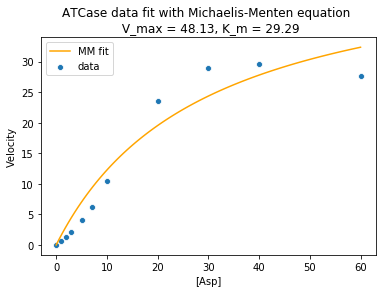

In [5]:
## Fitting data to the MM equation

# Define the MM equation as a variable
def MM_func(x,v_max, k_m):
    return (x*v_max)/(k_m + x)

# Use curve_fit from scipy.optimize to fit our data!
popt_mm, pcov_mm = curve_fit(MM_func, asp, specific_activity)

print(f"Predicted V_max = {popt_mm[0]}, K_m = {popt_mm[1]}")


# Plot our predicted curve on the scatterplot
sns.scatterplot(asp,specific_activity, label = "data")

# To make things smoother, we'll add a bunch of x-values...
plt.plot(np.linspace(0,60,100), MM_func(np.linspace(0,60,100), *popt_mm), color = "orange", label = "MM fit")
plt.legend()
plt.xlabel("[Asp]")
plt.ylabel("Velocity")
plt.title(f"ATCase data fit with Michaelis-Menten equation \n V_max = {popt_mm[0]:.2f}, K_m = {popt_mm[1]:.2f}");

plt.savefig("fig_3.pdf")

Much better!!



Still doesn't fit the ATCase data so well. One reason is because ATCase is a *cooperative enzyme*, meaning that the binding of one substrate influences the binding of the next. This sort of situation is better described by the **Hill equation**

$$ velocity = \frac{V_{max}[S]^n}{K_m^n + [S]^n}$$

where $V_{max}$ is the maximum velocity of the enzyme, $K_m$ is basically the same as the $K_m$ above, and $n$ is the Hill coefficient which describes the amount of cooperativity ($n=1$ for no cooperativity, $n>1$ for cooperativity). The Hill equation famously describes the oxygen binding in haemoglobin.


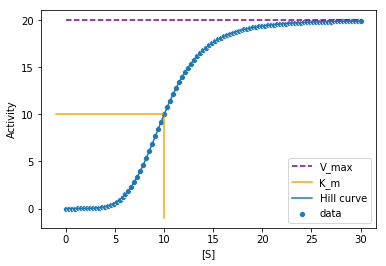

In [6]:
## Example Hill curve - note the sigmoidal shape

substrate = np.linspace(0,30,100)  # mM concentration
V_max = 20
K_m = 10
n = 5 # Within the range of haemoglobin
product = V_max * (substrate**n/(K_m**n + substrate**n))

sns.scatterplot(substrate, product, label = "data")
ax =sns.lineplot(substrate, V_max*np.ones(substrate.shape), dashes=[(6, 1)], label = "V_max", color = "purple")
ax.lines[0].set_linestyle("--")
plt.plot([K_m, K_m], [-1, 0.5*V_max], color = "orange")
plt.plot([-1, K_m], [0.5*V_max, 0.5*V_max], color = "orange", label = "K_m")
sns.lineplot(substrate, product, label = "Hill curve")
plt.legend()
plt.xlabel("[S]")
plt.ylabel("Activity")

plt.savefig("fig_4.pdf")

Does the Hill equation fit the ATCase data well?

Predicted V_max = 30.107369977060365, n = 2.5321254597961653, K_m = 12.011341613169483


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


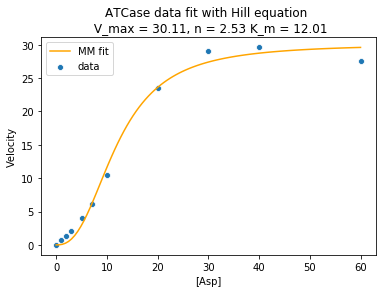

In [7]:
# Fit the ATCase data to the Hill equation

# Define the Hill function
def Hill_func(x,v_max, n, k_m):
    return (v_max*x**n)/(k_m**n + x**n)

# Use curve_fit from scipy.optimize to fit our data!
popt_hill, pcov_hill = curve_fit(Hill_func, asp, specific_activity)

print(f"Predicted V_max = {popt_hill[0]}, n = {popt_hill[1]}, K_m = {popt_hill[2]}")

# Plot our predicted curve on the scatterplot
sns.scatterplot(asp,specific_activity, label = "data")

# To make things smoother, we'll add a bunch of x-values...
plt.plot(np.linspace(0,60,100), Hill_func(np.linspace(0,60,100), *popt_hill), color = "orange", label = "MM fit")
plt.legend()
plt.xlabel("[Asp]")
plt.ylabel("Velocity")
plt.title(f"ATCase data fit with Hill equation \n V_max = {popt_hill[0]:.2f}, n = {popt_hill[1]:.2f} K_m = {popt_hill[2]:.2f}");

plt.savefig("fig_5.pdf")

Wow very nice!

The Hill equation does a nice job of capturing the sigmoidal nature of the data. ATCase actually follows the Monod-Wyman-Changeux kinetics model which is slightly more complicated, so we will stop here with the Hill equation fitting.

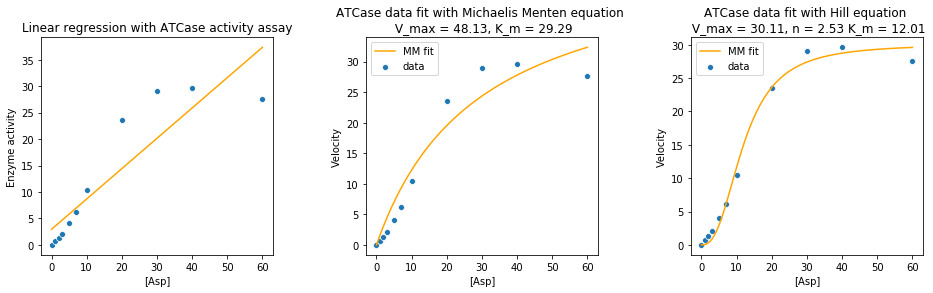

In [8]:
## Show all three plots together

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)

# Linear regression
sns.scatterplot(asp, specific_activity)

# Calculate line of best fit
# from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(asp.reshape(-1,1), specific_activity.reshape(-1,1))
a_atcase = regr.intercept_
b_atcase = regr.coef_[0]

y_hats_atcase = a_atcase + b_atcase*asp

# Plot the line of best fit
sns.lineplot(asp,y_hats_atcase, color="orange")
plt.xlabel("[Asp]")
plt.ylabel('Enzyme activity')
plt.title('Linear regression with ATCase activity assay');



plt.subplot(1,3,2)

# Plot our predicted MM curve on the scatterplot
sns.scatterplot(asp,specific_activity, label = "data")

# To make things smoother, we'll add a bunch of x-values...
plt.plot(np.linspace(0,60,100), MM_func(np.linspace(0,60,100), *popt_mm), color = "orange", label = "MM fit")
plt.legend()
plt.xlabel("[Asp]")
plt.ylabel("Velocity")
plt.title(f"ATCase data fit with Michaelis Menten equation \n V_max = {popt_mm[0]:.2f}, K_m = {popt_mm[1]:.2f}");


plt.subplot(1,3,3)
# Plot our predicted Hill curve on the scatterplot
sns.scatterplot(asp,specific_activity, label = "data")

# To make things smoother, we'll add a bunch of x-values...
plt.plot(np.linspace(0,60,100), Hill_func(np.linspace(0,60,100), *popt_hill), color = "orange", label = "MM fit")
plt.legend()
plt.xlabel("[Asp]")
plt.ylabel("Velocity")
plt.title(f"ATCase data fit with Hill equation \n V_max = {popt_hill[0]:.2f}, n = {popt_hill[1]:.2f} K_m = {popt_hill[2]:.2f}");


plt.subplots_adjust(bottom=None, right=1, top=None, wspace=0.4, hspace = 0.4)

plt.savefig("fig_6.pdf")

------
## Other examples of nonlinear fitting - Quadratic equations

Perhaps the first nonlinear function that came to mind was not the Michaelis-Menten equation but something simpler like a quadratic. 
$$ y = a+bx+cx^2$$
We can also fit quadratic functions to our data. Let's take a look at how that works...

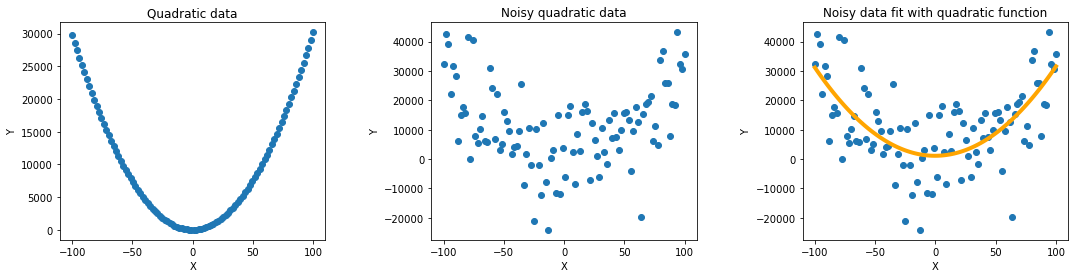

In [9]:
# First let's define x and y values
x_quad = np.linspace(-100,100,100)
y_quad = 5+2*x_quad+ 3*x_quad**2

# add noise
y_quad_noise = y_quad + 10000 * np.random.normal(size=x_quad.size)


# define quadratic fit a + b*(x-c)**2
def quad_func(x,a,b,c):
    return a + b*x+c*x**2

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.scatter(x_quad, y_quad)
plt.title("Quadratic data")
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1,3,2)
plt.scatter(x_quad, y_quad_noise)
plt.title("Noisy quadratic data")
plt.xlabel("X")
plt.ylabel("Y")

popt_quad, pcov_quad = curve_fit(quad_func, x_quad, y_quad_noise)
plt.subplot(1,3,3)
plt.scatter(x_quad, y_quad_noise)
plt.plot(x_quad, quad_func(x_quad, *popt_quad), '-',
         color ="orange",
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_quad),
         linewidth = 4)
plt.title("Noisy data fit with quadratic function")
plt.xlabel("X")
plt.ylabel("Y")


plt.subplots_adjust(bottom=None, right=1, top=None, wspace=0.4, hspace = 0.4)

plt.savefig("fig_7.pdf")

------
## Other examples of nonlinear fitting - Smoothing

Sometimes you do not have an underlying idea of the function that describes your data. In these scenarios, sometimes just getting a general idea of the data pattern can be helpful. One way to do this is through smoothing. 

There are many ways one can smoooth data. We'll demonstrate a sliding window average approach. To create a smoothed curve with a sliding window, we'll set some window width, start at the left-most part of the data, and average together all y-values within one window width. Then we will move one data point to the right and continue until we have reached the end of the data.

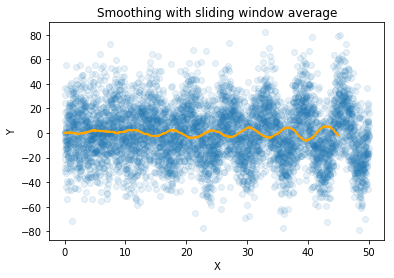

In [10]:
# Sliding window smoothing example. This implementation assumes that we sampled at regularly-spaced intervals.

# Define some data
x = np.linspace(0,50,5500)
y = 0.5*x*np.sin(x) + 20 * np.random.normal(size=x.size)

# Set the window size -- adjust this parameter to control the amount of smoothing
window_size = 550

# Compute the sliding window averages
smoothed_y = np.array([])

for i in np.arange(y.size-window_size):

    y_window_mean = np.mean(y[i:i+window_size])
    smoothed_y = np.append(smoothed_y,[y_window_mean])
    

# Plot!
plt.scatter(x,y, alpha = 0.1)
sns.lineplot(x[:-window_size],smoothed_y, color="orange", lw=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Smoothing with sliding window average")

plt.savefig("fig_9.pdf")

-----
## Logisitc regression

What if when we're collecting data, the recovered variable is categorical, such as survived vs. died? Or is a gray squirrel vs is a brown squirrel? Clearly these types of data do not make sense for linear regression. 

Let's examine some toy data to get a better idea of the problems...


Data table | X=0| X=1 | X=2 | X=3 | X=4 | X=5 | X=6 | X=7 | X=8 | X=9
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Yes Y=1 | 0 | 0 | 0 | 1 | 0 | 1 | 1 | 0 | 1 | 1 
No Y=0 | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 1 | 0 | 0

What does this data look like? Could we fit it with a line?

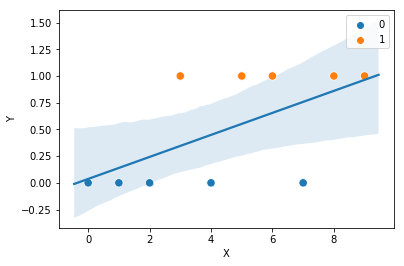

In [11]:
lg_x = np.arange(10)
lg_y = [0, 0, 0, 1, 0, 1, 1, 0, 1, 1]

# Just using regplot to plot a line of best fit
sns.regplot(lg_x, lg_y)
sns.scatterplot(lg_x, lg_y, hue = lg_y, s=70)
plt.xlabel("X")
plt.ylabel("Y");

plt.savefig("fig_10.pdf")

Clearly that did not go so well. The line tells us nothing about the relationships in the data. Even if it did, our data violate the assumptions of linear regression! The residuals will not be normally distributed because the points are binary, and the variance of the residuals is not constant.

What do we do?

Let's use another data example to make the next point a little more clear:


Data table | X=0| X=1 | X=2 | X=3 | X=4 | X=5 | X=6 | X=7 | X=8 | X=9
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Yes Y=1 | 0 | 2 | 6 | 3 | 9 | 11 | 20 | 22 | 23 | 21 
No Y=0 | 25 | 23 | 19 | 22 | 16 | 14 | 5 | 3 | 2 | 4

Now we have counts of 1s and 0s for each value of x. We had this same data above, but the counts were either 1 or 0 so not so interesting. Let's plot these data...

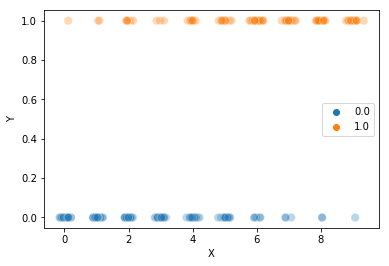

In [15]:
# Make a vector of the above and plot

x_vals = np.arange(10)
yes_counts = np.array([1, 2, 6, 3, 9, 11, 20, 22, 23, 24])
no_counts = np.array([24, 23, 19, 22, 16, 14, 5, 3, 2, 1])

# Expand the counts into a vector to make plotting easier
x_vals_exp = np.array([])
data_vec = np.array([])
for x_i in x_vals:
    
    # I know there are 25 records for each x value
    x_vals_exp = np.append(x_vals_exp, x_i * np.ones(25))
    
    additional_yes = np.ones(yes_counts[x_i])
    additional_nos = np.zeros(no_counts[x_i])
    data_vec = np.append(data_vec, additional_yes)
    data_vec = np.append(data_vec, additional_nos)
    

# Plot the data with a little noise in the x-values so that we can see all the points
sns.scatterplot(x_vals_exp + 0.1*np.random.normal(size=x_vals_exp.size), data_vec, hue = data_vec, alpha = 0.3, s = 70)
plt.xlabel("X")
plt.ylabel("Y");


We are dealing with counts of 1s and 0s at each $x_i$. Seem familiar? If we assume that at each $x_i$, there exists a binomial distribution with probability $p_{x_i}$ of success, then we really need to understand how these probabilities change across values of X. In order to start understanding these probabilities, recall the odds of Y (Y the yes variable) are

$$ Odds(Y) = \frac{Y}{1-Y} $$

Let's calculate the odds of Y and plot those atop our scatterplot...

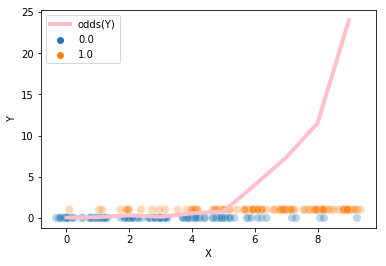

In [16]:
# Calculate the odds
y_odds = yes_counts/((25-yes_counts))

sns.scatterplot(x_vals_exp + 0.2*np.random.normal(size=x_vals_exp.size), data_vec, hue = data_vec, s=70, alpha = 0.3)
sns.lineplot(x_vals, y_odds, color = "pink", lw=4, label = "odds(Y)")
plt.xlabel("X")
plt.ylabel("Y");


If you had to choose a transform to make the odds plot linear -- what would you choose? The log transform!

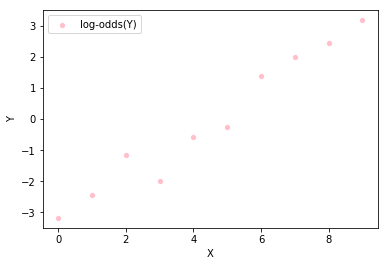

In [19]:
# sns.scatterplot(x_vals_exp + 0.2*np.random.normal(size=x_vals_exp.size), data_vec, hue = data_vec, s=70, alpha = 0.3)
sns.scatterplot(x_vals, np.log(y_odds), color = "pink", lw=4, label = "log-odds(Y)")
plt.xlabel("X")
plt.ylabel("Y");


That's pretty close to a line! Let's fit the log-odds of Y $ =ln[\frac{Y}{1-Y}]$ to a line using linear regression as usual. So we want to fit
$$ ln[\frac{Y}{1-Y}] = \alpha + \beta X$$

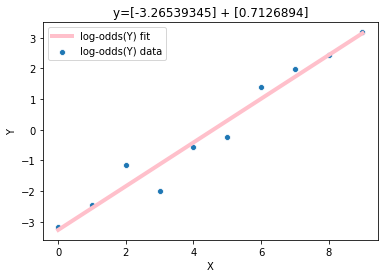

In [20]:
# Plot the scatterplot of log odds
sns.scatterplot(x_vals, np.log(y_odds), label = "log-odds(Y) data")

# Run linear regression between x values and log-odds of Y
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(x_vals.reshape(-1,1), np.log(y_odds).reshape(-1,1))
a_logit = regr.intercept_
b_logit = regr.coef_[0]

# Plot!
sns.lineplot(x_vals, a_logit + b_logit*x_vals, color = "pink", lw=4, label = "log-odds(Y) fit")
plt.title(f'y={regr.intercept_} + {regr.coef_[0]}')
plt.xlabel("X")
plt.ylabel("Y");


We have moved very far from our original scatterplot of 1s and 0s, huh? Let's move back in that direction by converting the *predicted log-odds* to the *predicted odds*. Remember, our linear model helped us predict the log-odds of $Y$, so we need to transform the predicted log-odds slightly to get back to odds and then to predicted proportions.

Let's say we predicted the log-odds of Y and we call them $\hat{lo(Y)}$ (this differs from your book's notation but I think theirs is confusing). 

$$ \hat{lo(Y)} = ln[\frac{\hat{Y}}{1-\hat{Y}}]$$

$$ e^{\hat{lo(Y)}} = \frac{\hat{Y}}{1-\hat{Y}}$$

$$ e^{\hat{lo(Y)}} - e^{\hat{lo(Y)}}\hat{Y} = \hat{Y}$$

$$ e^{\hat{lo(Y)}} = Y(1+ e^{\hat{lo(Y)}})$$

$$ \frac{e^{\hat{lo(Y)}}}{1+e^{\hat{lo(Y)}}} = \hat{Y}$$

What happens when we transform back to $\hat{Y}$= the predicted proportion of 1s?

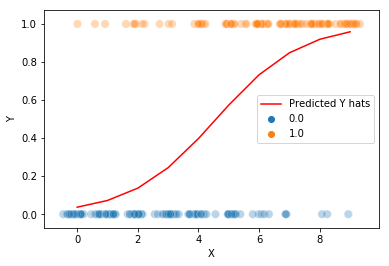

In [21]:
lo_yhats = a_logit + b_logit*x_vals
y_hats = np.exp(lo_yhats)/(1 + np.exp(lo_yhats))

# Plot!
sns.lineplot(x_vals, y_hats, color = "red", label = "Predicted Y hats")
sns.scatterplot(x_vals_exp + 0.2*np.random.normal(size=x_vals_exp.size), data_vec, hue = data_vec, s=70, alpha = 0.3)
plt.xlabel("X")
plt.ylabel("Y");

# plt.savefig("fig_11.pdf")

Congratulations, you have just performed a brute force logistic regression :)

### Logistic regression example 1 - toy data

Logistic regression can be used in many scenarios. Luckily, the `sklearn` package as built in functions that perform all the heavy-lifting for you. We'll demonstrate first on our toy data from above and then move to more interesting examples.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy = 0.816


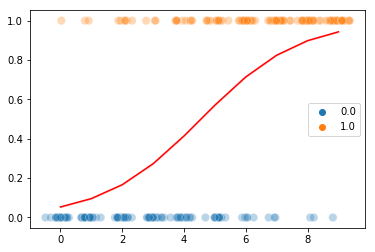

In [22]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import column_or_1d


# Define the model with our x values (x_valus_exp) and y values (data_vec)
model = LogisticRegression(random_state=0).fit(x_vals_exp.reshape(-1,1), column_or_1d(data_vec))

# Now have the model compute the expected proportions of 1s at each value of x
y_hats_logit = model.predict_proba(x_vals_exp.reshape(-1,1))[:,1]

# Plot the original data and the prediction from the logistic regression
sns.scatterplot(x_vals_exp + 0.2*np.random.normal(size=x_vals_exp.size), data_vec, hue = data_vec, s=70, alpha = 0.3)
sns.lineplot(x_vals_exp, y_hats_logit, color = "red")

# We can evaluate the accuracy of our model using model.score.
print(f'Accuracy = {model.score(x_vals_exp.reshape(-1,1), data_vec)}')


### Logistic regression example 2 - dabrafenib dose curve

Using data from the [Broad and CTD2](https://depmap.org/portal/compound/dabrafenib?tab=dose-curves), let's see how well we can fit the response of a lymphoma cell line PFEIFFER to increasing amounts of the BRAF V600E inhibitor dabrafenib.

In order to match the data to our presentations thus far, let's assume the researchers began with 1000 cells. Then at each dose, they recorded the number alive after some fixed period of time. The actual data is given to us in proportions, but we'll convert it to counts.

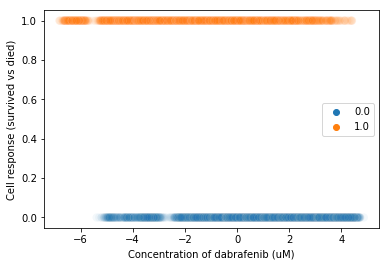

In [23]:
# Concentration of debrafenib in micromoles
doses = np.log(np.array([0.002, 0.041, 0.0081, 0.016, 0.032, 0.065, 0.13, 0.26, 0.52, 1.0, 2.1, 4.2, 8.3, 17., 33., 66.]))

# Counts of alive cells after debrafenib response
deb_response = 1000 * np.array([1.03, 0.925, 0.904, 0.906, 0.755, 1.09, 0.758, 0.540, 0.395, 0.321, 0.207, 0.194, 0.185, 0.136, 0.0749, 0.0200])

# Artificially threshold at 1000
deb_response[deb_response>1000] = 1000

# Expand into long count vectors
doses_exp = np.array([])
responses_vec = np.array([])
for i,x_i in enumerate(doses):
    
    # I know there are 1000 records for each x value
    doses_exp = np.append(doses_exp, x_i * np.ones(1000))
    
    additional_survived = np.ones(int(deb_response[i]))
    additional_died = np.zeros(1000 - int(deb_response[i]))
    responses_vec = np.append(responses_vec, additional_survived)
    responses_vec = np.append(responses_vec, additional_died)
    
sns.scatterplot(doses_exp + 0.2*np.random.normal(size=doses_exp.size), responses_vec, hue = responses_vec, s=70, alpha = 0.051)
plt.xlabel("Concentration of dabrafenib (uM)")
plt.ylabel("Cell response (survived vs died)");


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy = 0.8285


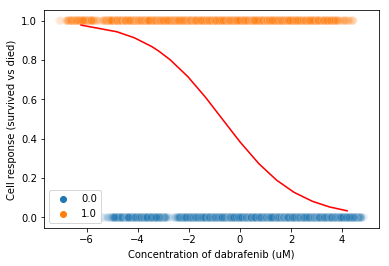

In [24]:
## Logistic regression on dabrafenib dose data
model = LogisticRegression(random_state=0).fit(doses_exp.reshape(-1,1), column_or_1d(responses_vec, warn =True))

# Now have the model compute the expected proportions of 1s at each value of x
y_hats_logit = model.predict_proba(doses_exp.reshape(-1,1))[:,1]

# Plot the original data and the prediction from the logistic regression
sns.scatterplot(doses_exp + 0.2*np.random.normal(size=doses_exp.size), responses_vec, hue = responses_vec, s=70, alpha = 0.1)
plt.xlabel("Concentration of dabrafenib (uM)")
plt.ylabel("Cell response (survived vs died)");
sns.lineplot(doses_exp, y_hats_logit, color = "red")

# We can evaluate the accuracy of our model using model.score.
print(f'Accuracy = {model.score(doses_exp.reshape(-1,1), responses_vec)}')


### Logistic regression example 3 - caffeine predictions

Caffeine can make you more alert and better at certain tasks. Does it make you appreciably better? Can I predict if you had caffeine based on your performance at two simple tasks?

In [25]:
# Did you have caffeine today?
caffeine_yn = np.array(['No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes',
       'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes',
       'No', 'Yes', 'No', 'Yes'])

# How long can you keep your eyes open before you blink?
eyes_time = np.array([ 16.  ,  58.67,  10.  ,  89.  ,  15.  ,   8.  ,  37.  ,  21.02,
       220.  ,  56.  ,  99.  ,  20.  ,  11.  ,  17.  ,  22.  ,  11.25,
        14.  , 103.66, 103.  ,  21.  ,  19.  , 285.  ,  75.  ,   6.  ,
        98.  ,  26.  ,  12.1 ,  25.  ,  17.2 ,  30.  ,  96.  ,  74.  ,
        75.  ,  15.  ,  15.  ,  11.  ,  65.  ,   9.  ,  16.3 ,  30.  ,
        11.  ,  34.  ,  32.81,  19.  ,  67.  ,  42.  ,  13.  ,  31.  ,
        99.  ,  34.  ,   8.  ,   5.  ,  50.  ,  30.  ])

# How long can you stand on one leg?
one_leg = np.array([  80.  ,  304.  ,  374.  ,   72.  ,  360.  ,  103.  ,  285.  ,
         31.75,  301.  ,  150.  ,  316.  ,   60.  ,   37.  ,   45.  ,
        144.  ,  113.94,  120.  ,   73.57,   42.  ,  120.  ,  264.  ,
        213.  ,   59.  ,  302.  ,  218.  ,   82.  ,   90.  ,  186.  ,
        317.6 ,  257.  ,  281.  ,   56.  ,   33.  , 9535.  ,  270.  ,
         35.  ,  130.  ,   62.  ,  209.  ,   60.  ,  109.  ,  600.  ,
        360.  ,  672.  ,   56.  ,   22.  ,   76.  ,  240.  ,   65.  ,
         88.  ,   45.  ,  191.  ,   60.  ,  180.  ])

In [26]:
# Let's turn caffeine into a binary vector
caffeine_bin = 1*(caffeine_yn=="Yes")
caffeine_bin

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Let's try with the eye-open timing data first.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy = 0.6296296296296297


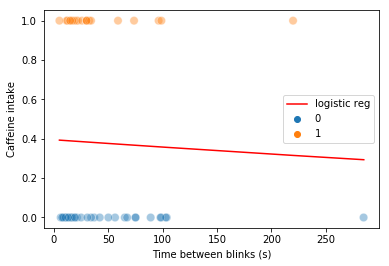

In [27]:
# Now let's do the logistic regression!
model = LogisticRegression(random_state=0).fit(eyes_time.reshape(-1,1), column_or_1d(caffeine_bin, warn =True))

# Now have the model compute the expected proportions of 1s at each value of x
y_hats_logit = model.predict_proba(eyes_time.reshape(-1,1))[:,1]

# Plot the original data and the prediction from the logistic regression
sns.scatterplot(eyes_time + 0.2*np.random.normal(size=eyes_time.size), caffeine_bin, hue = caffeine_bin, s=70, alpha = 0.4)
plt.xlabel("Time between blinks (s)")
plt.ylabel("Caffeine intake");
sns.lineplot(eyes_time, y_hats_logit, color = "red", label = "logistic reg")

# We can evaluate the accuracy of our model using model.score.
print(f'Accuracy = {model.score(eyes_time.reshape(-1,1), caffeine_bin)}')


## Exercise - perform a logistic regression on the time standing on one-leg data.

Upload a screenshot of your regression to Canvas.